# **CIS 520: Machine Learning, Fall 2022**
# **LDA HW**




- **Content Checkers: Edward Li, Hyungseok (Paul) Roh, Keshav Ramji** 
- This worksheet is partially **adapted** from: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb#scrollTo=LOj40WjbveIX

 ## Download the Data

In [ ]:
# Imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [ ]:
categories = ['talk.politics.mideast', 'comp.graphics',
              'sci.med', 'rec.sport.baseball']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [ ]:
print(train.data[0])

From: rind@enterprise.bih.harvard.edu (David Rind)
Subject: Re: Arrhythmia
Organization: Beth Israel Hospital, Harvard Medical School, Boston Mass., USA
Lines: 26
NNTP-Posting-Host: enterprise.bih.harvard.edu

In article <1993Apr22.205509.23198@husc3.harvard.edu>
 perry1@husc10.harvard.edu (Alexis Perry) writes:
>In article <1993Apr22.031423.1@vaxc.stevens-tech.edu>
 u96_averba@vaxc.stevens-tech.edu writes:

>>doctors said that he could die from it, and the medication caused

>	Is it that serious?  My EKG often comes back with a few irregular
>beats.  Another question:  Is a low blood potassium level very bad?  My
>doctor seems concerned, but she tends to worry too much in general.

The term arrhythmia is usually used to encompass a wide range of abnormal
heart rhythms (cardiac dysrhythmias).  Some of them are very serious
while others are completely benign.  Having "a few irregular beats"
on an EKG could be serious depending on what those beats were and
when they occurred, or could be

Can you guess which of the four topics this document belongs to?

## LDA Training

Let's build out our LDA model and fit our training data. 

Note that we need to first preprocess our data using a CountVectorizor(). Then you can build an LDA model with 4 n_components and a random_state of 0. See if you can encapsulate this into a single pipeline (check out make_pipeline()).


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = make_pipeline(CountVectorizer(), LatentDirichletAllocation(n_components=4, random_state=0))
lda.fit(train.data)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(n_components=4, random_state=0))])

Now, let's write a prediction function for our test data. We should run the data through the model to get out class probabilities for each datapoint, and then argmax those probabilities to get out a prediction. The transform() function might come in useful here.

In [ ]:
def lda_predict(data, model):
  # TODO: Write a prediction function for LDA
  transform = model.transform(data)
  y_pred = np.argmax(transform, axis=1) # Get prediction using the maximum probability
  return y_pred

In [ ]:
y_pred = lda_predict(test.data, lda)
print(y_pred)

[2 3 3 ... 1 0 0]


## 2.5.1 Confusion Matrix

Build a confusion matrix for your predictions vs. actual labels and compute the accuracy for the matrix. Record both in your writeup.

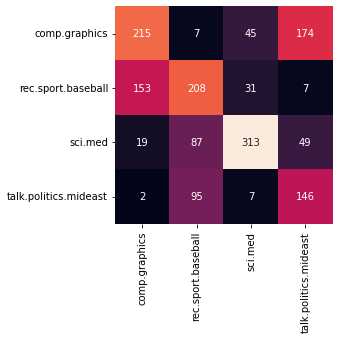

In [ ]:
## TODO: Construct your confusion matrix here. 
mat = confusion_matrix(test.target, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)


In [ ]:
# TODO: Determine the accuracy of the confusion matrix here.
acc = mat.diagonal().sum()/mat.sum()
print(acc)


0.5661103979460848


Beware that even though we specified 4 categories for the LDA model, we did NOT say which topic is which. However, looking at the confusion matrix, we see that the LDA model is able to distinguish the differences between the categories to a great extent.

Describe any discrepancies and misclassification you see between the predicted topics and the actual topics. Give two possible factors that might diminish the performance of the LDA and briefly explain them. Record your response in the writeup.


## 2.5.2 Document-Topic Matrix

Now that we have trained our LDA model, we can take a closer look at what the model affords us. One such useful piece of information we can get out of the model is a "document-topic" matrix, which tells us that given a document, what are the probabilities that document belongs in each class? We can access this through the transform() method as follows:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
lda.transform(train.data)

array([[0.27368128, 0.00120189, 0.72390835, 0.00120848],
       [0.30555006, 0.00195677, 0.69051891, 0.00197427],
       [0.08159284, 0.00113477, 0.72161358, 0.1956588 ],
       ...,
       [0.19640593, 0.00206544, 0.79942354, 0.00210509],
       [0.00149275, 0.9491492 , 0.04786503, 0.00149302],
       [0.09902997, 0.89481898, 0.00303892, 0.00311213]])

Here, we ran the training data through the trained LDA, and what we get out for each document is a vector of length 4, where each element is the corresponding probability that that document belongs to that particular class. You can verify this yourself by adding the four probabilities up--they should sum to 1!

Hmm...this looks awfully like a dataset, and numbers are a lot easier to work with than documents of words. Plus, we already know what the labels are:

In [ ]:
train.target

array([2, 2, 2, ..., 2, 1, 0])

What if we use the LDA model to transform our document data into these probability vectors, and use this transformed data as an input to a classification model? In fact, something similar has actually been done before [here](https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28).

Let's see if we can recreate a simplified version here, using multiclass logistic regression.

In [ ]:
logistic = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state=0)


In [ ]:
# TODO: Fit the logistic regressor on lda-transformed training data and labels

logistic.fit(lda.transform(train.data),train.target)

LogisticRegression(multi_class='multinomial', random_state=0)

What are the coefficients and intercepts in this trained model?

In [ ]:
# TODO: what are the computed intercepts?

logistic_intercept = logistic.intercept_
print(logistic_intercept)

[-0.67205662  0.37393217 -0.17023523  0.46835968]


In [ ]:
# TODO: what are the computed coefficients?

coefficients = logistic.coef_
print(coefficients)

[[ 2.05034084  3.48910394 -0.48090578 -5.06047443]
 [-3.88900895  2.46901226 -0.8643668   2.28538379]
 [ 0.46985768 -1.66632609  2.10441663 -0.90809465]
 [ 1.36881043 -4.2917901  -0.75914405  3.68318529]]


Now let's see if we can get out predictions. Multiply your coefficient matrix with your lda-transformed TEST data matrix and add your bias terms. Then, taking the argmax of each row should yield your predicted class for the test data.

In [ ]:
# TODO: Make predictions on TEST data.
prediction = np.add(lda.transform(test.data)@coefficients.T,logistic_intercept)
y_prediction = np.argmax(prediction, axis=1)
print(y_prediction)


[2 3 3 ... 1 3 3]


Compute the confusion matrix and *weighted* F1 score and include them in the writeup.

0.7780489588050767


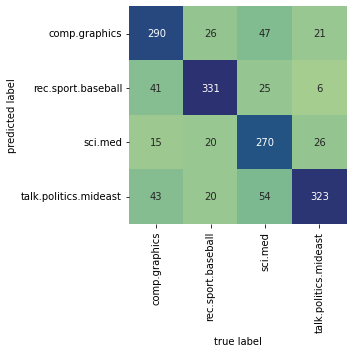

In [ ]:
## TODO: Construct your confusion matrix here. 
matrix = confusion_matrix(test.target, y_prediction)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap = 'crest',
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

f1score = f1_score(test.target, y_prediction,average='weighted')
print(f1score)


Do your results align with what you would expect? Why or why not? Record your thoughts in the writeup.

## 2.5.3 Topic-Term Matrix

The other piece of information we can extract from our trained LDA model is a topic-term matrix. You can do so by making a call to the .components_ attribute on your LDA model:

In [ ]:
lda[1].components_
print(lda[1].components_)
print(np.array(lda[1].components_).shape)
print(np.array(train.data).shape)

[[ 64.14361922 100.63665876   2.22163244 ...   0.28775286   0.26109064
    0.2500038 ]
 [219.28544255  58.52523881   0.25016452 ...   0.25441101   1.23635215
    2.07778532]
 [ 22.1120397   28.65062333   0.25000076 ...   1.20782949   0.25255392
    0.41132378]
 [  3.45889853 143.1874791    0.27820228 ...   0.25000664   0.25000328
    0.2608871 ]]
(4, 38113)
(2339,)


Look closely at this matrix. What does the topic-term matrix tell us? Record your thoughts in your homework writeup.

Hint: Check out the dimensionality of the matrix.

## 2.5.4 Visualizing each Topic

Now, your task is to print out the 10 most common or influential words that the model has learned for each of the four topics.

*Hint: You will need to first find the indices of the 10 highest values for each topic: argsort() could be useful here. Then use the provided vocabulary to extract out those selected terms.*

In [ ]:
from numpy.ma.core import argsort
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train.data)
vocab = vectorizer.get_feature_names()

topic_words = {}

for topic, comp in enumerate(lda[1].components_):
  # TODO: Complete this section.
  word_idx = argsort(comp)[::-1]
  topic_words[topic] = [ vocab[i] for i in word_idx[:10] ]

for topic, words in topic_words.items():
  print('Topic: %d' % topic)
  print('  %s' % ', '.join(words))

Topic: 0
  the, of, to, and, in, is, that, for, it, you
Topic: 1
  the, edu, to, in, for, and, of, from, subject, lines
Topic: 2
  the, of, to, is, in, and, that, it, edu, this
Topic: 3
  the, and, of, to, in, that, was, they, he, it


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Do these words make sense for their corresponding topics? Do you see any limitations? Briefly explain and record your thoughts in the writeup.